# Egg segm. from centre with GraphCut

A simple obejct segmentation method using Graph Cut over whole image initilised from a few initial seeds.

In [1]:
%matplotlib inline
import os, sys, glob
import numpy as np
import pandas as pd
from PIL import Image
# from scipy import spatial, ndimage
from skimage import segmentation as sk_segm
import matplotlib.pylab as plt

In [3]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import imsegm.utilities.data_io as tl_io
import imsegm.superpixels as tl_spx
import imsegm.region_growing as tl_rg

## Loading data

In [4]:
COLORS = 'bgrmyck'
PATH_IMAGES = tl_io.update_path(os.path.join('data_images', 'drosophila_ovary_slice'))
print ([os.path.basename(p) for p in glob.glob(os.path.join(PATH_IMAGES, '*')) if os.path.isdir(p)])
dir_img = os.path.join(PATH_IMAGES, 'image')
dir_segm = os.path.join(PATH_IMAGES, 'segm')
dir_annot = os.path.join(PATH_IMAGES, 'annot_eggs')
dir_center = os.path.join(PATH_IMAGES, 'center_levels')

['center_levels', 'image', 'annot_struct', 'annot_eggs', 'segm_rgb', 'segm']


In [5]:
name = 'insitu7545'
img = np.array(Image.open(os.path.join(dir_img, name + '.jpg')))
seg = np.array(Image.open(os.path.join(dir_segm, name + '.png')))
centers = pd.read_csv(os.path.join(dir_center, name + '.csv'), index_col=0).values
centers[:, [0, 1]] = centers[:, [1, 0]]
FIG_SIZE = (8. * np.array(img.shape[:2]) / np.max(img.shape))[::-1]

/usr/local/lib/python3.5/dist-packages/IPython/kernel/__main__.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


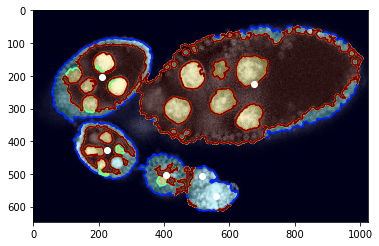

In [6]:
# plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.imshow(seg, alpha=0.2, cmap=plt.cm.jet), plt.contour(seg, cmap=plt.cm.jet)
_= plt.plot(centers[:, 1], centers[:, 0], 'ow')

### Superpixels

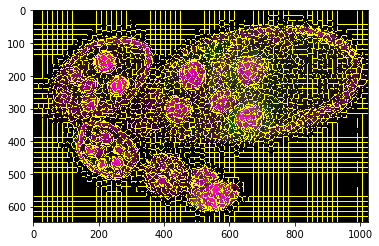

In [7]:
slic = tl_spx.segment_slic_img2d(img, sp_size=15, rltv_compact=0.3)
_= plt.imshow(sk_segm.mark_boundaries(img, slic))

## Obejct segmentation on pixel level

Estimating eggs with just single global GraphCut on probability according structure segmentation and annotated centre points.

In [8]:
labels_fg_prob = [0.05, 0.7, 0.9, 0.9]

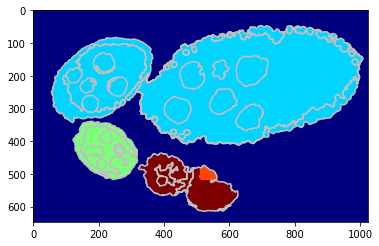

In [10]:
debug_visual = dict()
segm_obj = tl_rg.object_segmentation_graphcut_pixels(seg, centers, labels_fg_prob, gc_regul=1., 
                                                     seed_size=10, debug_visual=debug_visual)
#fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
_= plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Visualise the unary potential as maxima over join matrix U.

(7, 647, 1024) [0 1 2 3 4 5 6]


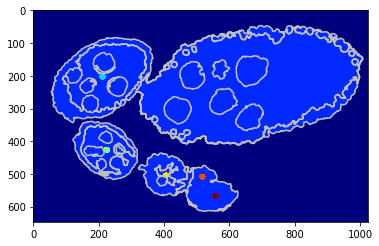

In [11]:
unary = np.array([u.tolist() for u in debug_visual['unary_imgs']])
print ('shape: %s and unique labels %s' % (repr(unary.shape), repr(np.unique(np.argmin(unary, axis=0)))))
#fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(np.argmin(unary, axis=0), cmap=plt.cm.jet)
_ = plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

### Using a shape prior

Similar scenarion as berore but in this case we draw a cicrcular shaper prior around each center wchich helps beter egg identification.

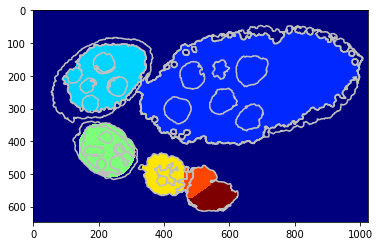

In [12]:
debug_visual = dict()
segm_obj = tl_rg.object_segmentation_graphcut_pixels(seg, centers, labels_fg_prob, gc_regul=2., seed_size=10, 
                                                     coef_shape=0.1, shape_mean_std=(50., 10.), debug_visual=debug_visual)
#fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
_= plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Visualise the unary potential as maxima over join matrix U.

(7, 647, 1024) [0 1 2 3 4 5 6]


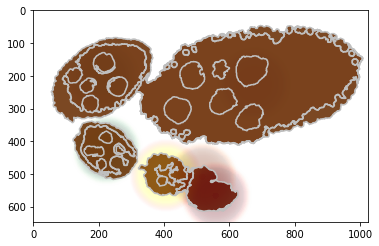

In [13]:
unary = np.array([u.tolist() for u in debug_visual['unary_imgs']])
print ('shape: %s and unique labels %s' % (repr(unary.shape), repr(np.unique(np.argmin(unary, axis=0)))))
#fig = plt.figure(figsize=FIG_SIZE)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')
CMAPS = [plt.cm.Greys, plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.autumn, plt.cm.Oranges, plt.cm.Reds]
for i in range(1, len(unary)):
    im = 1 - (unary[i, :, :] / np.max(unary[i, :, :]))
    im = (im * 1000).astype(int)
    lut = CMAPS[i](range(1001))
    lut[:, 3] = np.linspace(0, 0.7, 1001)
    plt.imshow(lut[im], alpha=1)

## Obejct segmentation on SLIC level

We replicate the previous methods but apply on superpixels - flat unary potential.

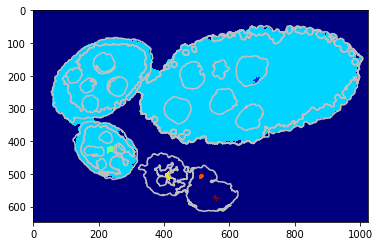

In [15]:
debug_visual = dict()
gc_labels = tl_rg.object_segmentation_graphcut_slic(slic, seg, centers, labels_fg_prob, gc_regul=2., edge_coef=1., 
                                                    edge_type='ones', add_neighbours=True, debug_visual=debug_visual)
segm_obj = np.array(gc_labels)[slic]

#fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
_ = plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Visualise the unary potential as maxima over join matrix U.

(7, 647, 1024) [0 1 2 3 4 5 6]


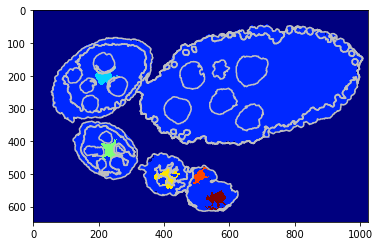

In [16]:
unary = np.array([u.tolist() for u in debug_visual['unary_imgs']])
print ('shape: %s and unique labels %s' % (repr(unary.shape), repr(np.unique(np.argmin(unary, axis=0)))))
#fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(np.argmin(unary, axis=0), cmap=plt.cm.jet)
_ = plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

### Using a shape prior

We replicate the previous methods but apply on superpixels - unary potential with circular shape prior.

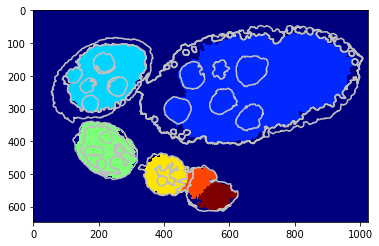

In [17]:
debug_visual = dict()
gc_labels = tl_rg.object_segmentation_graphcut_slic(slic, seg, centers, labels_fg_prob, gc_regul=1., edge_coef=1., 
                                                    edge_type='ones', coef_shape=0.1, shape_mean_std=(50., 10.), 
                                                    add_neighbours=False, debug_visual=debug_visual)
segm_obj = np.array(gc_labels)[slic]
#fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
_= plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Visualise the unary potential as maxima over join matrix U.

(7, 647, 1024) [0 1 2 3 4 5 6]


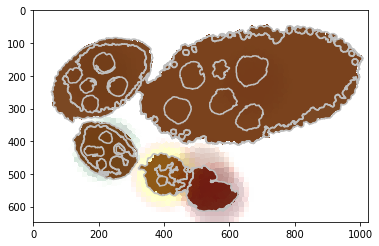

In [18]:
unary = np.array([u.tolist() for u in debug_visual['unary_imgs']])
print ('shape: %s and unique labels %s' % (repr(unary.shape), repr(np.unique(np.argmin(unary, axis=0)))))
#fig = plt.figure(figsize=FIG_SIZE)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')
CMAPS = [plt.cm.Greys, plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.autumn, plt.cm.Oranges, plt.cm.Reds]
for i in range(1, len(unary)):
    im = 1 - (unary[i, :, :] / np.max(unary[i, :, :]))
    im = (im * 1000).astype(int)
    lut = CMAPS[i](range(1001))
    lut[:, 3] = np.linspace(0, 0.7, 1001)
    plt.imshow(lut[im], alpha=1)